our model would overfit to the training data. Learning how to deal with overfitting is important. Although it's often possible to achieve high accuracy on the training set, what you really want is to develop models that generalize well to a testing set (or data they haven't seen before).

The opposite of overfitting is underfitting. Underfitting occurs when there is still room for improvement on the train data. This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. This means the network has not learned the relevant patterns in the training data.

If you train for too long though, the model will start to overfit and learn patterns from the training data that don't generalize to the test data. You need to strike a balance. Understanding how to train for an appropriate number of epochs as you'll explore below is a useful skill.

To prevent overfitting, the best solution is to use more complete training data. The dataset should cover the full range of inputs that the model is expected to handle. Additional data may only be useful if it covers new and interesting cases.

A model trained on more complete data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like regularization. These place constraints on the quantity and type of information your model can store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

In this notebook, you'll explore several common regularization techniques, and use them to improve on a classification model.

In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.18.0


In [3]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to c:\users\lenovo\appdata\local\temp\pip-req-build-b4v3qd0o
  Resolved https://github.com/tensorflow/docs to commit 15e96c3ee154d7c10ec9bb807ef44b4e6f08e65b
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached PyYAML-6.0.2-cp311-cp311-win_amd64.whl.metadata (2.1 kB)
  Using cached fastjsonschema-2.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached attrs-24.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached referencing-0.35.1-py3-none-any.whl.metadata (2.8 kB)
Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Using cached PyYAML-6.0.2-cp311

  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\lenovo\AppData\Local\Temp\pip-req-build-b4v3qd0o'


In [4]:


import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [5]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [ ]:
# logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"


In [ ]:
# logdir

WindowsPath('C:/Users/lenovo/AppData/Local/Temp/tmpdofna47q/tensorboard_logs')

In [7]:
shutil.rmtree(logdir, ignore_errors=True)

The Higgs dataset
The goal of this tutorial is not to do particle physics, so don't dwell on the details of the dataset. It contains 11,000,000 examples, each with 28 features, and a binary class label.

In [9]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 ━━━━━━━━━━━━━━━━━━━━ 631s 0us/step



A CSV.GZ file is a compressed CSV (Comma Separated Values) file, typically utilized for storing and transferring large datasets. The GZ extension indicates that the file is compressed using the Gzip algorithm, which reduces the file size for easier storage and transmission.

In [33]:
gz

'C:\\Users\\lenovo\\.keras\\datasets\\HIGGS.csv.gz'

In [10]:
import urllib

In [20]:
author = '%E0%A6%AE%E0%A6%B9%E0%A6%AE%E0%A7%8D%E0%A6%AE%E0%A6%A6'

In [21]:
urllib.parse.unquote_plus(f'{author}')

'মহম্মদ'

In [22]:
urllib.parse.unquote_plus(author)

'মহম্মদ'

In [23]:
FEATURES = 28

The tf.data.experimental.CsvDataset class can be used to read csv records directly from a gzip file with no intermediate decompression step.

In [24]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

gz: Path to the CSV.GZ file.
[float()] * (FEATURES + 1): Expected data type and number of columns. float() specifies the data type, and (FEATURES + 1) defines the number of columns.
compression_type="GZIP": Specifies the compression algorithm used.

In [32]:
ds

<CsvDatasetV2 element_spec=(TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None), Ten

That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

*row: Accepts variable number of arguments (rows).
label = row[0]: Extracts first column (label/target variable).
features = tf.stack(row[1:], 1):
Selects remaining columns (features).
Stacks them into a tensor.
Axis=1: stacks along columns.
return features, label: Returns features and label tensors.

In [25]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

TensorFlow is most efficient when operating on large batches of data.

So, instead of repacking each row individually make a new tf.data.Dataset that takes batches of 10,000 examples, applies the pack_row function to each batch, and then splits the batches back up into individual records:

In [26]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

ds.batch(10000): Groups the dataset (ds) into batches of 10,000 rows.
.map(pack_row): Applies the pack_row function to each batch. This function transforms/ processes each batch.
.unbatch(): Splits the processed batches back into individual rows.
Purpose

In [31]:
packed_ds

<_UnbatchDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [69]:
packed_ds.TensorSpec

AttributeError: '_UnbatchDataset' object has no attribute 'TensorSpec'

Inspect some of the records from this new packed_ds.

The features are not perfectly normalized

tf.Tensor(
[[ 0.8692932  -0.6350818   0.22569026 ...  0.72165745  0.98875093
   0.87667835]
 [ 0.9075421   0.32914728  0.35941187 ...  0.77973217  0.99235576
   0.7983426 ]
 [ 0.79883474  1.4706388  -1.6359748  ...  0.8032515   0.8659244
   0.7801176 ]
 ...
 [ 0.4814969  -0.44418392 -1.6454076  ...  0.64619136  0.6939376
   0.6955113 ]
 [ 0.56476605  0.26291743  0.5430709  ...  0.7223196   0.93818957
   0.8478069 ]
 [ 0.44105193  0.80152214 -0.33426744 ...  0.6051652   0.9711247
   0.89249057]], shape=(1000, 28), dtype=float32)
tf.Tensor(
[1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0.
 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0.
 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0.
 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 1

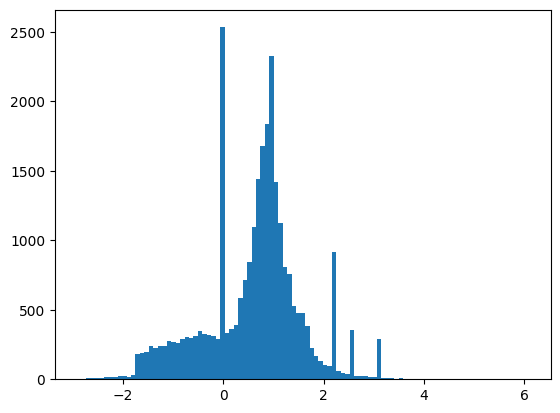

In [28]:
for features,label in packed_ds.batch(1000).take(1):
  print(features)
  print(label)
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

se just the first 1,000 samples for validation, and the next 10,000 for training:

In [ ]:
N_VALIDATION = int(1e3) #1000  1e3 is equal to 1000, or 1 times 10 to the third powe
N_TRAIN = int(1e4) #10000
BUFFER_SIZE = int(1e4) #10000
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE #20

The Dataset.skip and Dataset.take methods make this easy.

At the same time, use the Dataset.cache method to ensure that the loader doesn't need to re-read the data from the file on each epoch:

packed_ds: Preprocessed dataset.
take(N_VALIDATION): Extracts first N_VALIDATION rows for validation.
skip(N_VALIDATION): Skips N_VALIDATION rows, starting from training data.
take(N_TRAIN): Extracts next N_TRAIN rows for training.
.cache(): Stores datasets in memory for faster access.

In [35]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [36]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

These datasets return individual examples. Use the Dataset.batch method to create batches of an appropriate size for training. Before batching, also remember to use Dataset.shuffle and Dataset.repeat on the training set.

In [37]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

batch(BATCH_SIZE): Groups validation data into batches for efficient evaluation.
Training Dataset
.shuffle(BUFFER_SIZE): Randomizes training data order within the buffer size.
.repeat(): Repeats training data indefinitely for multiple epochs.
.batch(BATCH_SIZE): Groups training data into batches for efficient training.

In [ ]:
# Demonstrate overfitting
# The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".

# Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

# Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

# On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".

# Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.

# To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.

# Start with a simple model using only densely-connected layers (tf.keras.layers.Dense) as a baseline, then create larger models, and compare them.

# Training procedure
# Many models train better if you gradually reduce the learning rate during training. Use tf.keras.optimizers.schedules to reduce the learning rate over time:

Training procedure
Many models train better if you gradually reduce the learning rate during training. Use tf.keras.optimizers.schedules to reduce the learning rate over time:

nitial Learning Rate (0.001): Starting learning rate.
Decay Steps: Number of steps before learning rate decay (20 epochs × 1000 steps/epoch).
Decay Rate (1): Rate at which learning rate decays.
Staircase (False): Smooth decay; if True, decay occurs in discrete steps.
Inverse Time Decay Formula
lr(t) = initial_lr / (1 + decay_rate * t / decay_steps)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000, #20*1000
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

The code above sets a tf.keras.optimizers.schedules.InverseTimeDecay to hyperbolically decrease the learning rate to 1/2 of the base rate at 1,000 epochs, 1/3 at 2,000 epochs, and so on.


In [39]:
step = np.linspace(0,100000)
lr = lr_schedule(step)

Evaluates the learning rate schedule (lr_schedule) at specific steps.
Breakdown
np.linspace(0, 100000): Generates 50 evenly spaced values from 0 to 100,000 (default number of samples).
lr_schedule(step): Applies the inverse time decay learning rate schedule to each step.
Output
lr array contains the corresponding learning rates at each step.

In [41]:
step

array([     0.        ,   2040.81632653,   4081.63265306,   6122.44897959,
         8163.26530612,  10204.08163265,  12244.89795918,  14285.71428571,
        16326.53061224,  18367.34693878,  20408.16326531,  22448.97959184,
        24489.79591837,  26530.6122449 ,  28571.42857143,  30612.24489796,
        32653.06122449,  34693.87755102,  36734.69387755,  38775.51020408,
        40816.32653061,  42857.14285714,  44897.95918367,  46938.7755102 ,
        48979.59183673,  51020.40816327,  53061.2244898 ,  55102.04081633,
        57142.85714286,  59183.67346939,  61224.48979592,  63265.30612245,
        65306.12244898,  67346.93877551,  69387.75510204,  71428.57142857,
        73469.3877551 ,  75510.20408163,  77551.02040816,  79591.83673469,
        81632.65306122,  83673.46938776,  85714.28571429,  87755.10204082,
        89795.91836735,  91836.73469388,  93877.55102041,  95918.36734694,
        97959.18367347, 100000.        ])

In [42]:
lr

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([0.001     , 0.00090741, 0.00083051, 0.00076563, 0.00071014,
       0.00066216, 0.00062025, 0.00058333, 0.00055056, 0.00052128,
       0.00049495, 0.00047115, 0.00044954, 0.00042982, 0.00041176,
       0.00039516, 0.00037984, 0.00036567, 0.00035252, 0.00034028,
       0.00032886, 0.00031818, 0.00030818, 0.00029878, 0.00028994,
       0.00028161, 0.00027374, 0.0002663 , 0.00025926, 0.00025258,
       0.00024623, 0.0002402 , 0.00023445, 0.00022897, 0.00022374,
       0.00021875, 0.00021397, 0.0002094 , 0.00020502, 0.00020082,
       0.00019679, 0.00019291, 0.00018919, 0.00018561, 0.00018216,
       0.00017883, 0.00017563, 0.00017254, 0.00016955, 0.00016667],
      dtype=float32)>

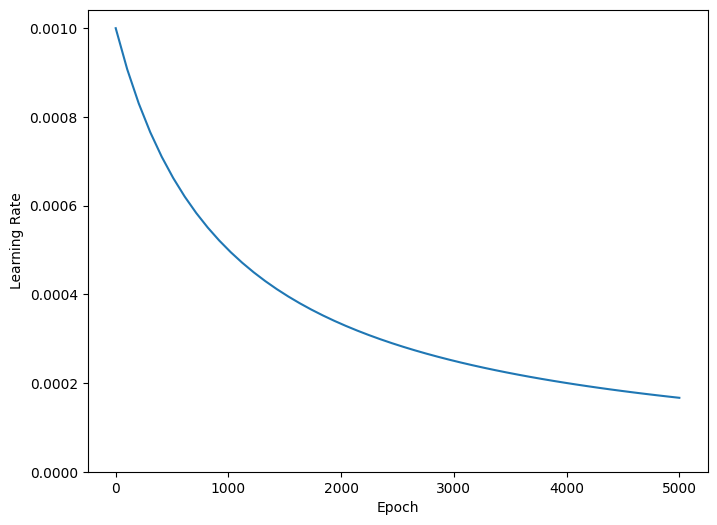

In [40]:
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

The training for this tutorial runs for many short epochs. To reduce the logging noise use the tfdocs.EpochDots which simply prints a . for each epoch, and a full set of metrics every 100 epochs.

In [43]:
import os

In [ ]:
# logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"

In [46]:
os.getcwd()

'd:\\a27_YEARS_OLD\\deep_learning\\tensoflow'

In [47]:
logdir = os.path.join(os.getcwd(),'tensorboard_logs')

In [48]:
logdir

'd:\\a27_YEARS_OLD\\deep_learning\\tensoflow\\tensorboard_logs'

In [57]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(os.path.join(logdir,name)),
  ]

In [54]:
def compile(model, optimizer=None):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  return model.summary()

def fit(model, name, max_epochs=100):

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

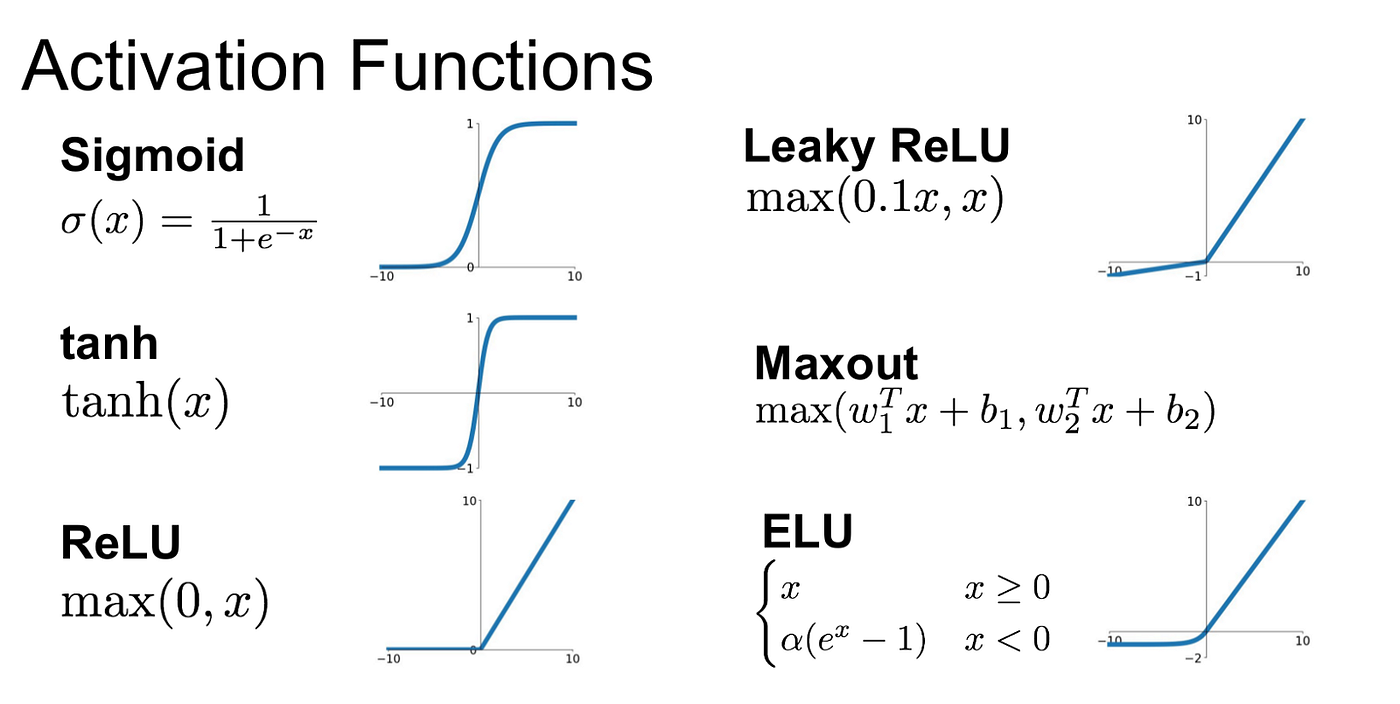

In [ ]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES, )),
    layers.Dense(1)
])

In [52]:
size_histories = {}

In [63]:
compile(tiny_model)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

ry to analyse your model using model.summary(), you will see the output shape after each layer. Also, don't forget to check your datasets.

In [58]:
size_histories['Tiny'] = fit(tiny_model, 'sizes/Tiny')

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 1)

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [65]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [64]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [66]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 753 (2.94 KB)

 Trainable params: 753 (2.94 KB)

 Non-trainable params: 0 (0.00 B)

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 1)

In [ ]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [ ]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Large model
As an exercise, you can create an even larger model and check how quickly it begins overfitting. Next, add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [ ]:

large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [ ]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

In [ ]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

View in TensorBoard
These models all wrote TensorBoard logs during training.

Open an embedded TensorBoard viewer inside a noteboo

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

In [ ]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

In [ ]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

Add weight regularization
You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as demonstrated in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero, encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights—one reason why L2 is more common.

In [ ]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

l2(0.001) means that every coefficient in the weight matrix of the layer will add 0.001 * weight_coefficient_value**2 to the total loss of the network.

In [ ]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

If you are writing your own training loop, then you need to be sure to ask the model for its regularization losses.

This implementation works by adding the weight penalties to the model's loss, and then applying a standard optimization procedure after that.

In [ ]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

Add dropout

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. For example, a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1].

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In [ ]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

In [ ]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

Combined L2 + dropout

In [ ]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

In [ ]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [ ]:
%tensorboard --logdir {logdir}/regularizers